In [1]:
# @title Importations
# installings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.optim as optim
from torch.nn.parameter import Parameter
import pickle
import scipy.io
from sklearn.metrics.pairwise import cosine_similarity
from fewbm.fit import ParamsJR, RNNWWD, Model_fitting, Costs
from nilearn.connectome import ConnectivityMeasure
import seaborn as sns


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
correlation_measure = ConnectivityMeasure(kind='correlation')

# Loading in Files

In [41]:
# choosing and loading data from dataset

def load_dataset(dataset='Schirner'):
    
    # Loading distances between nodes
    
    if dataset == 'Schirner':
    
        dist = pd.read_csv(r'C:\Users\Parsa\Datasets\Schirner\desikan_distances.csv', index_col=0)
        dist = dist.to_numpy()


        # loading and indexing structural connectivity matrix for each participant
        sub_SCs = {}
        all_sc = scipy.io.loadmat(r'C:\Users\Parsa\Datasets\Schirner\empirical_structural_connectomes\SCs.mat')

        for sub_id in range(all_sc['SC'].shape[1]):
            sc = all_sc['SC'][0][sub_id][0][0][0][0]
            sub_SCs[sub_id] = np.log1p(sc)/np.linalg.norm(np.log1p(sc))



        # loading and indexing fMRI time series for each participant
        sub_fMRIs = {}
        sub_fMRIs_ep = {}
        all_fmri = scipy.io.loadmat(r'C:\Users\Parsa\Datasets\Schirner\empirical_fMRI\empirical_fMRI.mat')

        
        for sub_id in range(all_fmri['fMRI'].shape[1]):
            sub_fMRIs[sub_id] = all_fmri['fMRI'][0][sub_id][0]
            # format of the time series should be (epochs,  nodes, time series)
            sub_fMRIs_ep[sub_id] = [sub_fMRIs[sub_id].T] * num_epochs
            sub_fMRIs_ep[sub_id] = np.array(sub_fMRIs_ep[sub_id])[:,:,:600]
            sub_fMRIs[sub_id] = sub_fMRIs[sub_id][:660,:]

    return dist, sub_SCs, sub_fMRIs_ep, dataset
    

In [42]:
# Setting model variables & priors


node_size = 68 # nodes for the Schirner data
output_size = 68 # same as node_size
input_size = 2 # model state size (WWD = 2)
tr = 1.94 # fMRI tr

num_epochs = 50 # times model fitting is ran
batch_size = 10 #
step_size = 0.05 #

dist, sub_SCs, sub_fMRIs_ep, dataset = load_dataset()

par = ParamsJR("WWD", g = [200, 0.05], g_EE= [5, 1.8], g_IE= [.5, 8], g_EI= [.5, 8],
                    std_in=[.05, 6],  mu = [2.5, 5])

In [43]:
def visualize_sim_WWD(sub_id, num_epochs=num_epochs, batch_size=batch_size, step_size=step_size, 
                      g = [200, 0.05], g_EE= [5, 1.8], g_IE= [.5, 8], g_EI= [.5, 8], std_in=[.05, 6],  mu = [2.5, 5]):
    
    par = ParamsJR("WWD", g=g, g_EE=g_EE, g_IE=g_IE, g_EI=g_EI, std_in=std_in, mu=mu)
    
    print('_____________________________________________________\nSTART\nSub ID: {}\nEpochs: {}\nBatch size: {}\nStep size: {}\nDataset: {}\n'.format(
        sub_id, num_epochs, batch_size, step_size, dataset)) 
    model = RNNWWD(input_size, node_size, batch_size, step_size, tr, sub_SCs[sub_id], dist, True, param = par)
    
    # format of the time series should be (epochs, nodes, time series)
    # the length of the time series should be divisible 
    fMRI_ts = np.array([sub_fMRIs[sub_id].T] * num_epochs)[:,:,:660]
    
    F = Model_fitting(model, sub_fMRIs_ep[sub_id], num_epochs, 1) 
    # last arguemnt above defines the cost function type (1 = functional connectivity Pearson correlation)
    
    # Training the model
    start_time = time.time()

    output_train = F.train()

    end_time =  time.time()
    print('Training time is  {0} \'s'.format(end_time - start_time ))
    
    # Testing model
    state_size = 6
    base_batch_num = 20 #should we change this?
    X0 = np.random.uniform(0, 5, (node_size, state_size))
    hE0 = np.random.uniform(0, 5, (node_size, 500))
    output_test = F.test(X0, hE0, base_batch_num)
    
    bold_sim = F.output_sim.bold_test
    
    # plotting pretty pictures
    
    f, ax = plt.subplots(5, figsize=(10,35))
    
    # first plot = loss function
    
    ax[0].plot(np.arange(num_epochs), F.output_sim.corrcoef)
    ax[0].set_title('Correlation between fc_sim and fc_emp')
    
    # second plot = simulated BOLD time series ()
    
    ax[1].plot(bold_sim[:,120:180].T)
    ax[1].set_title('Simulated BOLD - all nodes - min 2 to 3')
    
    # third plot = functional connectivity matrix - empirical 
    
    correlation_matrix = correlation_measure.fit_transform([sub_fMRIs[sub_id]])[0]
    np.fill_diagonal(correlation_matrix,0)
    
    sns.heatmap(correlation_matrix, cmap='RdBu_r', xticklabels=np.arange(0,node_size), 
                yticklabels=np.arange(0,node_size), vmin=-0.8, vmax=0.8, ax=ax[2])
    ax[2].set_title('Empirical functional connectivity')
    
    
    # fourth plot = functional connectivity matrix - simulated 
    
    correlation_matrix = correlation_measure.fit_transform([bold_sim.T])[0]
    np.fill_diagonal(correlation_matrix,0)
    
    sns.heatmap(correlation_matrix, cmap='RdBu_r', xticklabels=np.arange(0,node_size), 
                yticklabels=np.arange(0,node_size), vmin=-0.8, vmax=0.8, ax=ax[3])
    ax[3].set_title('Simulated functional connectivity')
    
    
    # fifth plot = functional connectivity matrix - simulated 
    
    correlation_matrix = correlation_measure.fit_transform([bold_sim.T])[0]
    np.fill_diagonal(correlation_matrix,0)
    
    sns.heatmap(correlation_matrix/np.max(correlation_matrix), cmap='RdBu_r', xticklabels=np.arange(0,node_size), 
                yticklabels=np.arange(0,node_size), vmin=-0.8, vmax=0.8, ax=ax[4])
    ax[4].set_title('Simulated functional connectivity - Max value normalized')
    
    plt.tight_layout()
    
    return F.output_sim



In [44]:
# use above function like this:
# output_sim = visualize_sim_WWD(...)

_____________________________________________________
START
Sub ID: 0
Epochs: 50
Batch size: 10
Step size: 0.05
Dataset: Schirner

epoch:  0 -3.3766189
epoch:  0 0.5775273973868673 cos_sim:  -0.023480453618718505
epoch:  1 -6.1551423
epoch:  1 0.28580560117281534 cos_sim:  -0.02350703651273908
epoch:  2 -8.308826
epoch:  2 0.5645761753633146 cos_sim:  -0.023387698618844908
epoch:  3 -9.222037
epoch:  3 0.4356484187409748 cos_sim:  -0.02365460010866622
epoch:  4 -9.984835
epoch:  4 0.5337555565966314 cos_sim:  -0.023377220026933453
epoch:  5 -10.551971
epoch:  5 0.5338375592821213 cos_sim:  -0.023160027968526592
epoch:  6 -11.07728
epoch:  6 0.6034073377262985 cos_sim:  -0.02408022419888774
epoch:  7 -11.4262905
epoch:  7 0.5586370733211692 cos_sim:  -0.023441428445448307
epoch:  8 -11.893857
epoch:  8 0.5641981120271468 cos_sim:  -0.023433109136077247
epoch:  9 -12.212686
epoch:  9 0.4945915680486751 cos_sim:  -0.023420253079359767
epoch:  10 -12.577208
epoch:  10 0.5865071216625857 co

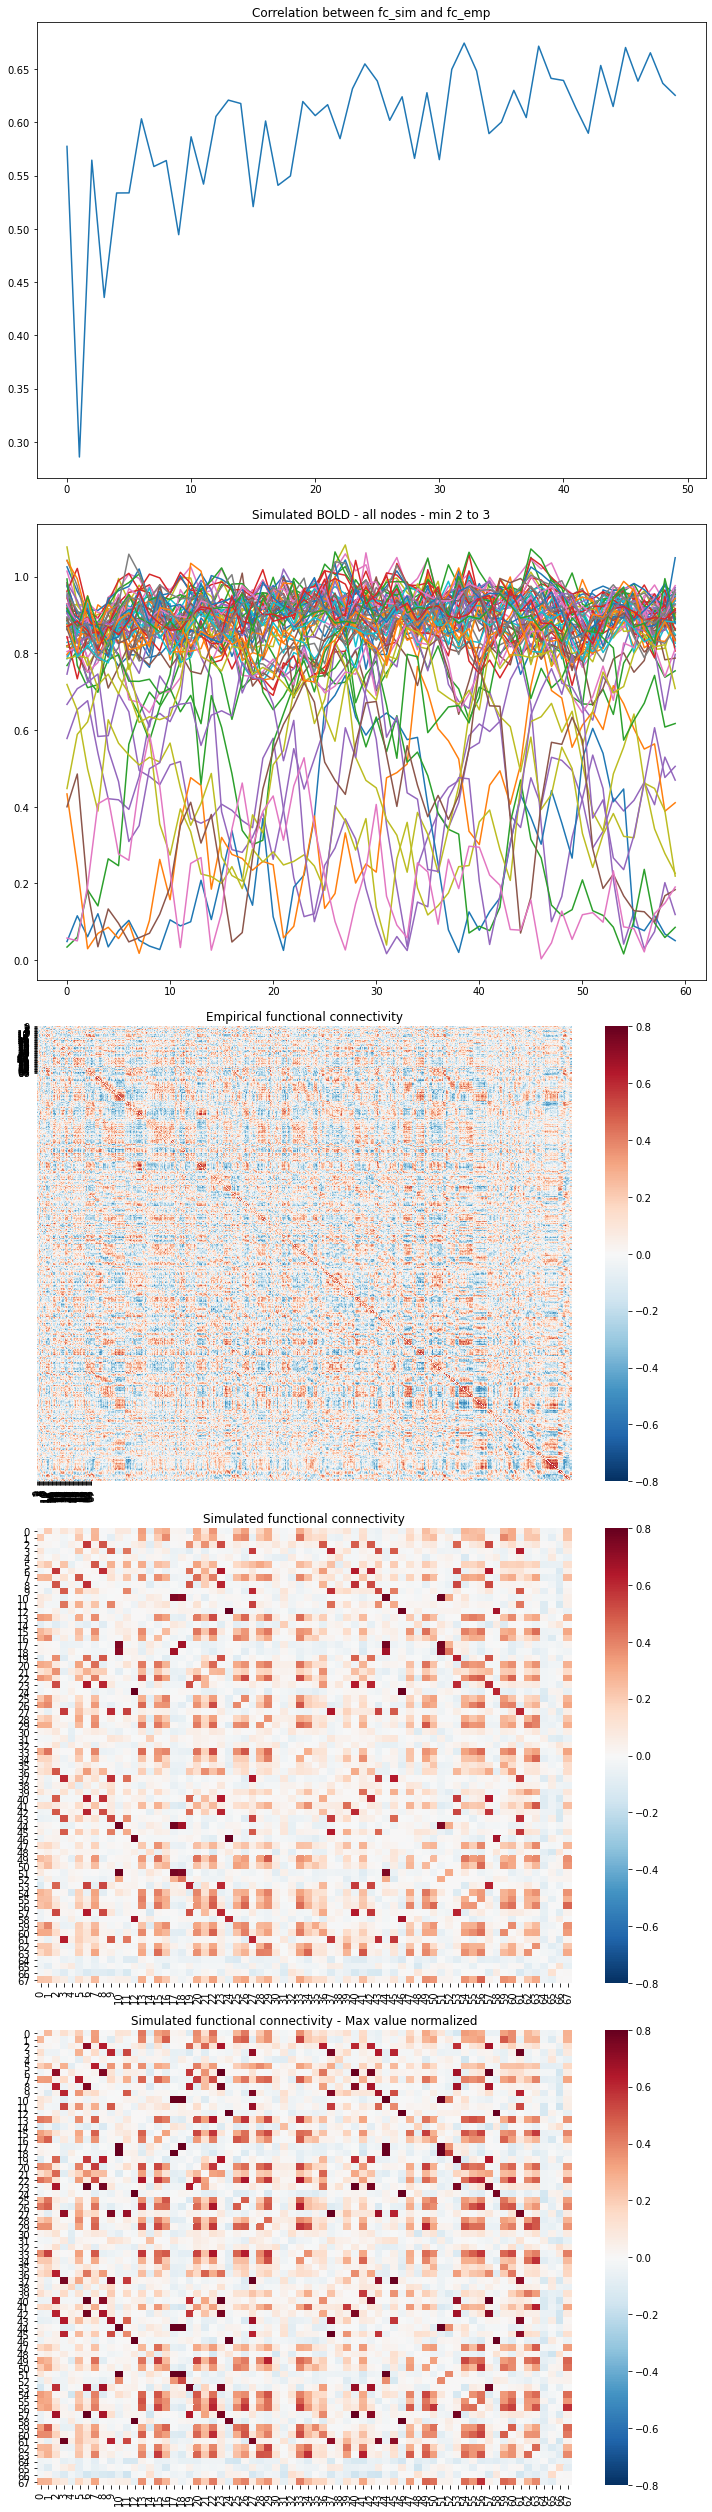

In [39]:
output_sim = visualize_sim_WWD(sub_id=0)

_____________________________________________________
START
Sub ID: 0
Epochs: 50
Batch size: 10
Step size: 0.05
Dataset: Schirner

epoch:  0 -8.005518
epoch:  0 0.4616615787677529 cos_sim:  -0.023822484986572676
epoch:  1 -9.724063
epoch:  1 0.2085026002094494 cos_sim:  -0.023663169417015212
epoch:  2 -10.816824
epoch:  2 0.24520650618303141 cos_sim:  -0.023412452848511206
epoch:  3 -11.634759
epoch:  3 0.22126909612016832 cos_sim:  -0.023646722092398428
epoch:  4 -12.252318
epoch:  4 0.2641630825182453 cos_sim:  -0.02358751250812182
epoch:  5 -12.806563
epoch:  5 0.3222104230031958 cos_sim:  -0.02365203602265878
epoch:  6 -13.296832
epoch:  6 0.37004731600046675 cos_sim:  -0.023655493763477364
epoch:  7 -13.7445755
epoch:  7 0.27244960081937336 cos_sim:  -0.02353292326675797
epoch:  8 -14.08417
epoch:  8 0.27090327814517484 cos_sim:  -0.023485596921850486
epoch:  9 -14.459373
epoch:  9 0.35571303124669346 cos_sim:  -0.02363380002561556
epoch:  10 -14.753551
epoch:  10 0.28319306578109

TypeError: 'set' object does not support item assignment

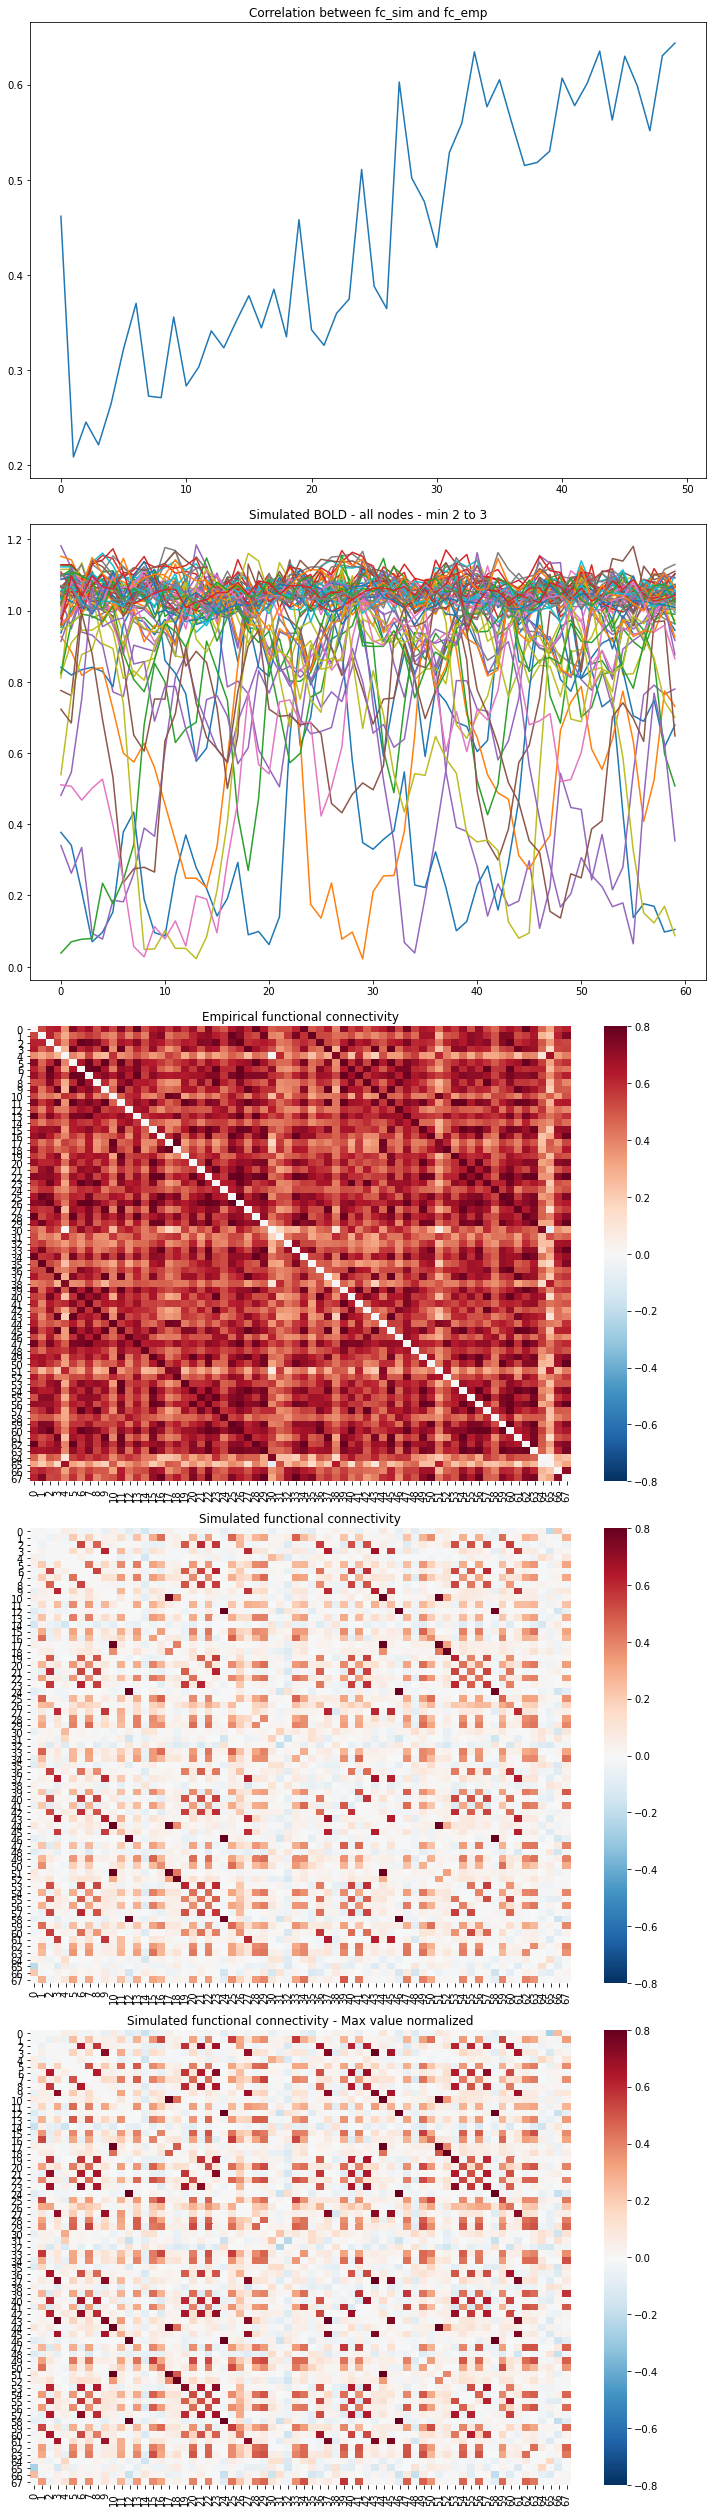

In [47]:
trained_models = {}
for i in range(5):
    trained_models[i] = visualize_sim_WWD(sub_id=i)

In [48]:
trained_models = {} # delete this cell later


_____________________________________________________
START
Sub ID: 0
Epochs: 50
Batch size: 10
Step size: 0.02
Dataset: Schirner

epoch:  0 0.037765052
epoch:  0 0.25368983144297685 cos_sim:  -0.024101654719663773
epoch:  1 -1.0630836
epoch:  1 0.29162744270134966 cos_sim:  -0.023453072547919028
epoch:  2 -1.9653649
epoch:  2 0.4490939760942821 cos_sim:  -0.023330071882499446
epoch:  3 -2.5968385
epoch:  3 0.44025738409474285 cos_sim:  -0.023414728199227634
epoch:  4 -3.1396284
epoch:  4 0.6028416406596252 cos_sim:  -0.02351943853509632
epoch:  5 -3.6570287
epoch:  5 0.5784079274068817 cos_sim:  -0.023391381834263942
epoch:  6 -4.1117454
epoch:  6 0.48530665187398125 cos_sim:  -0.02393949310251005
epoch:  7 -4.4498334
epoch:  7 0.4698803418117689 cos_sim:  -0.02402025286804292
epoch:  8 -4.8083816
epoch:  8 0.4803010554229148 cos_sim:  -0.023537497579803265
epoch:  9 -5.155068
epoch:  9 0.563702925003597 cos_sim:  -0.02403681482801746
epoch:  10 -5.413191
epoch:  10 0.5622770682833915

epoch:  46 -9.952956
epoch:  46 0.5732913009907821 cos_sim:  0.006199522287567175
epoch:  47 -10.075799
epoch:  47 0.5723564956245701 cos_sim:  0.004586365496863334
epoch:  48 -10.106688
epoch:  48 0.5396666497141938 cos_sim:  0.003951757965994017
epoch:  49 -10.18897
epoch:  49 0.5330792429871963 cos_sim:  0.0052481276617809365
Training time is  6074.972274780273 's
_____________________________________________________
START
Sub ID: 2
Epochs: 50
Batch size: 10
Step size: 0.02
Dataset: Schirner

epoch:  0 -0.69289863
epoch:  0 0.3965809958196832 cos_sim:  -0.005443143393879481
epoch:  1 -1.7083323
epoch:  1 0.44648107843758666 cos_sim:  -0.006693684019466856
epoch:  2 -2.5154517
epoch:  2 0.20510315722762365 cos_sim:  -0.006716978491043866
epoch:  3 -3.028352
epoch:  3 0.4216918008902963 cos_sim:  -0.006818739652666477
epoch:  4 -3.6101475
epoch:  4 0.2774957508722677 cos_sim:  -0.006598682852814751
epoch:  5 -4.0410166
epoch:  5 0.32794950487491653 cos_sim:  -0.006969129181523737
epoc

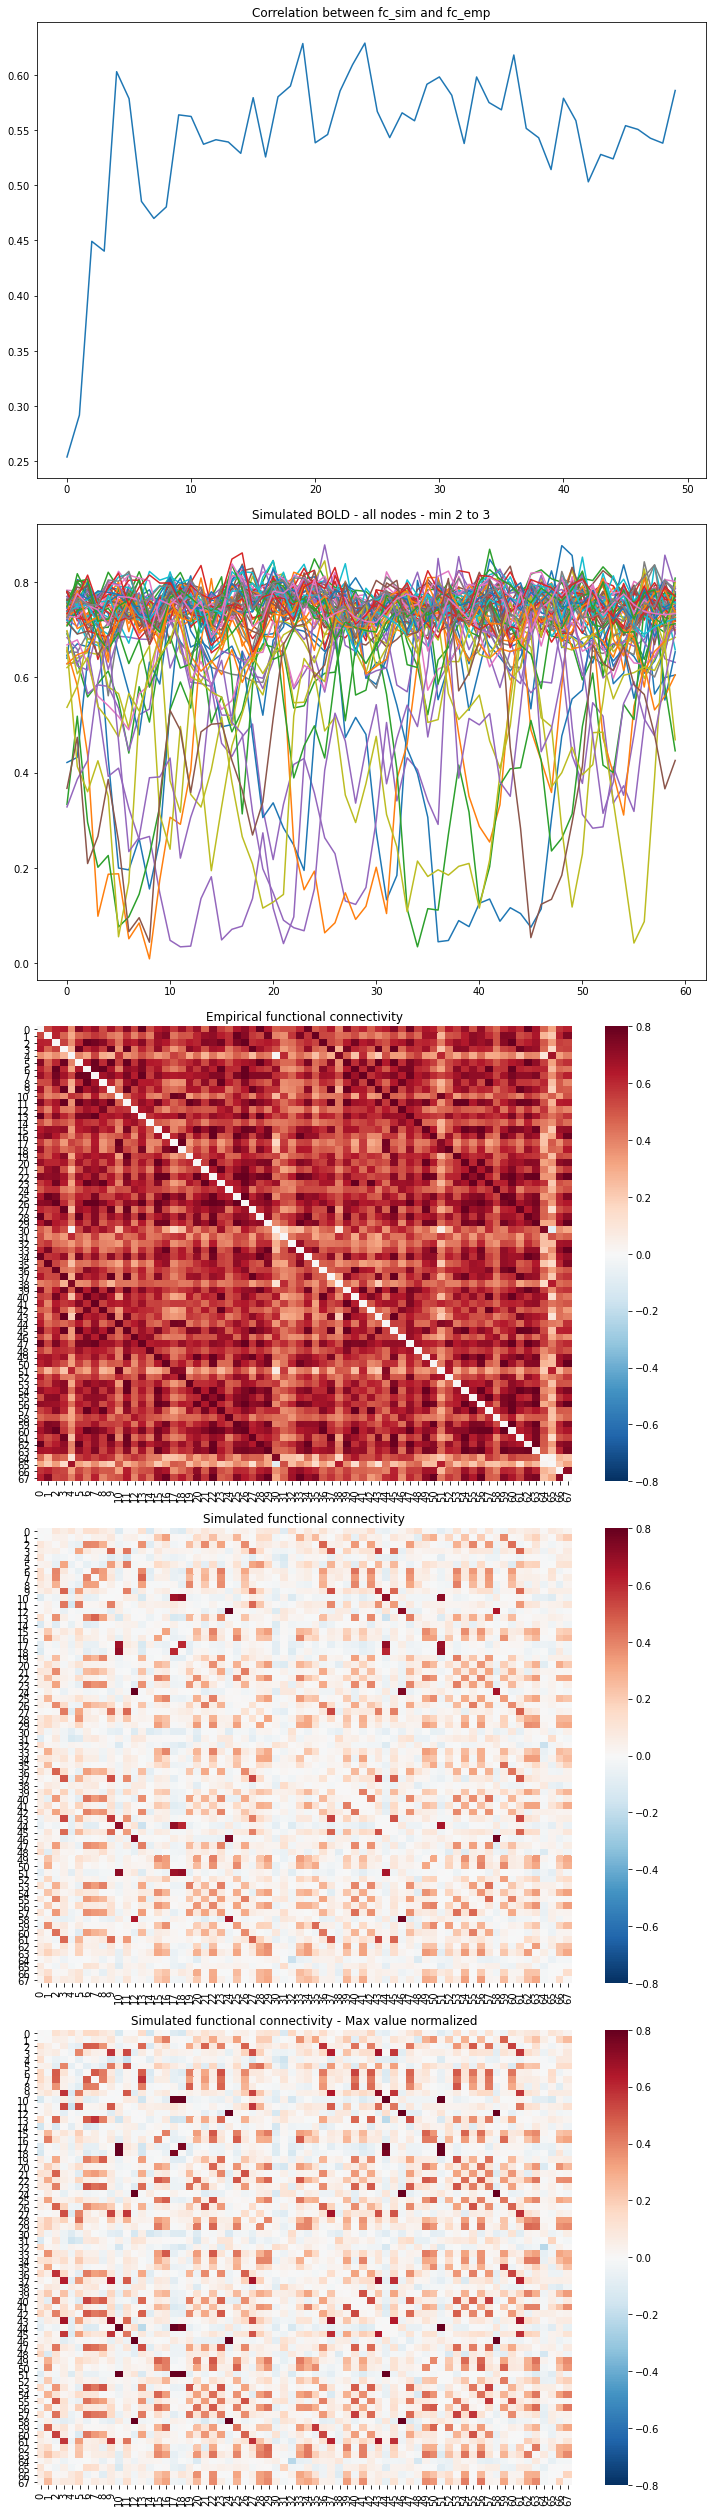

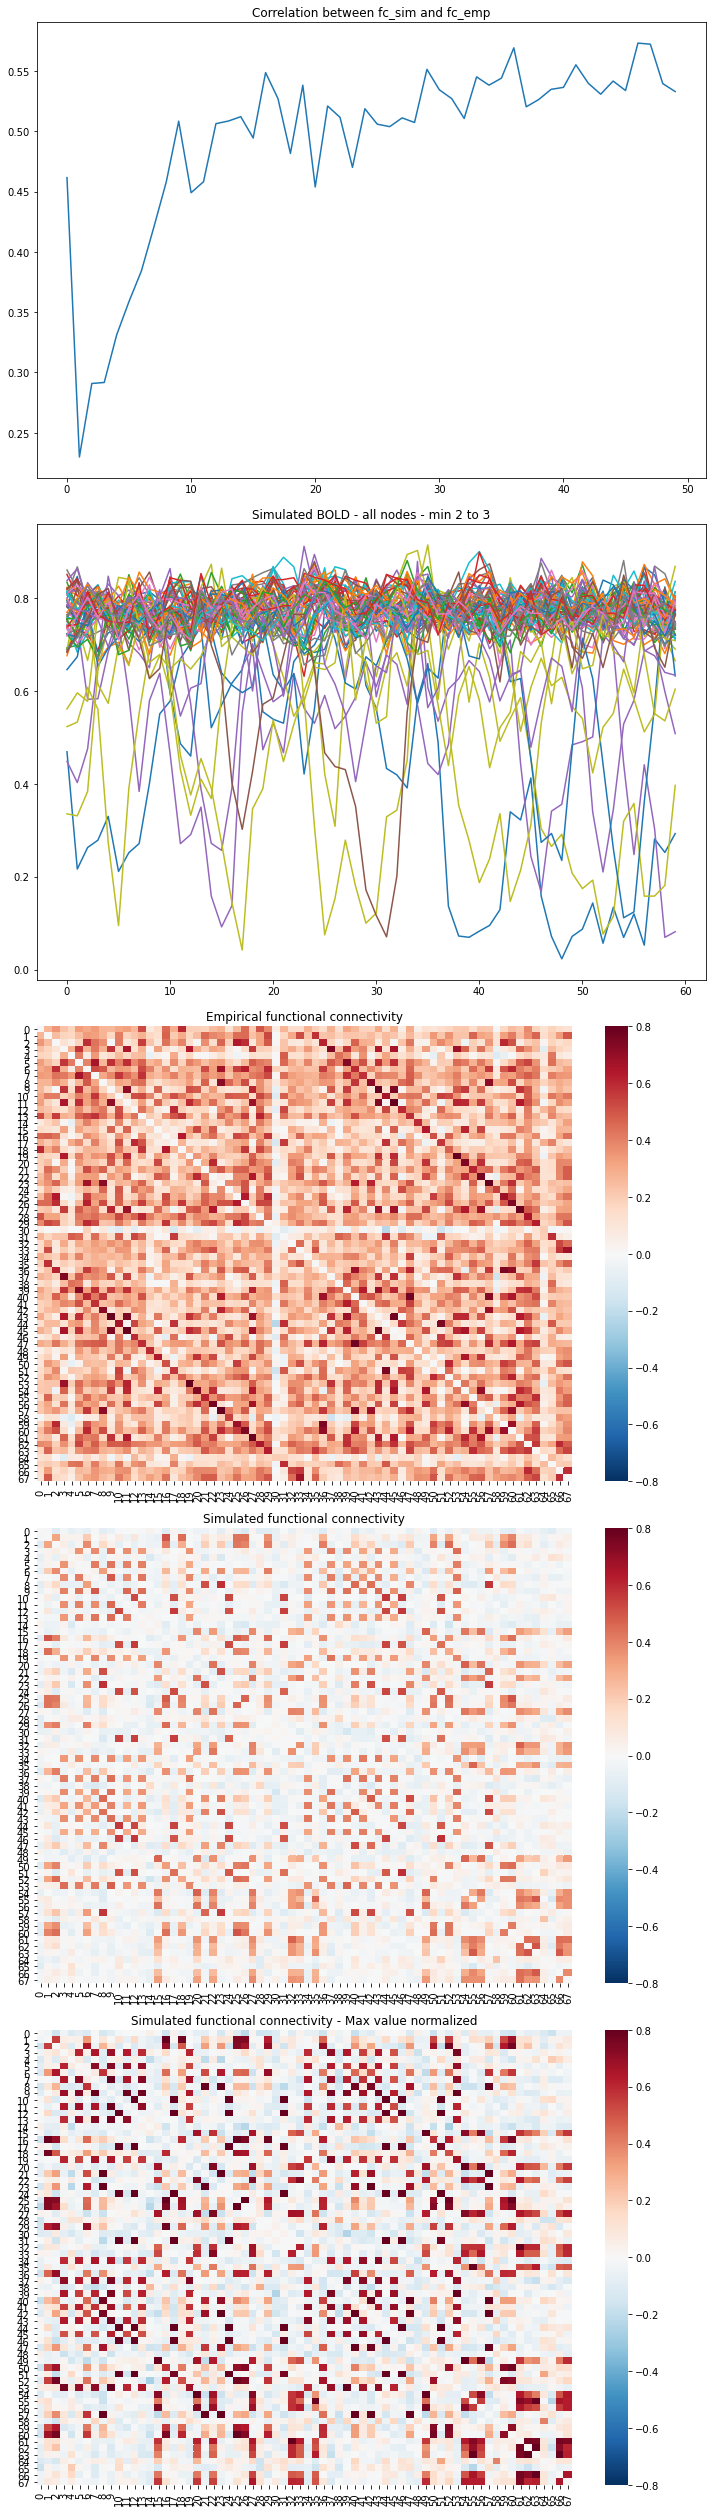

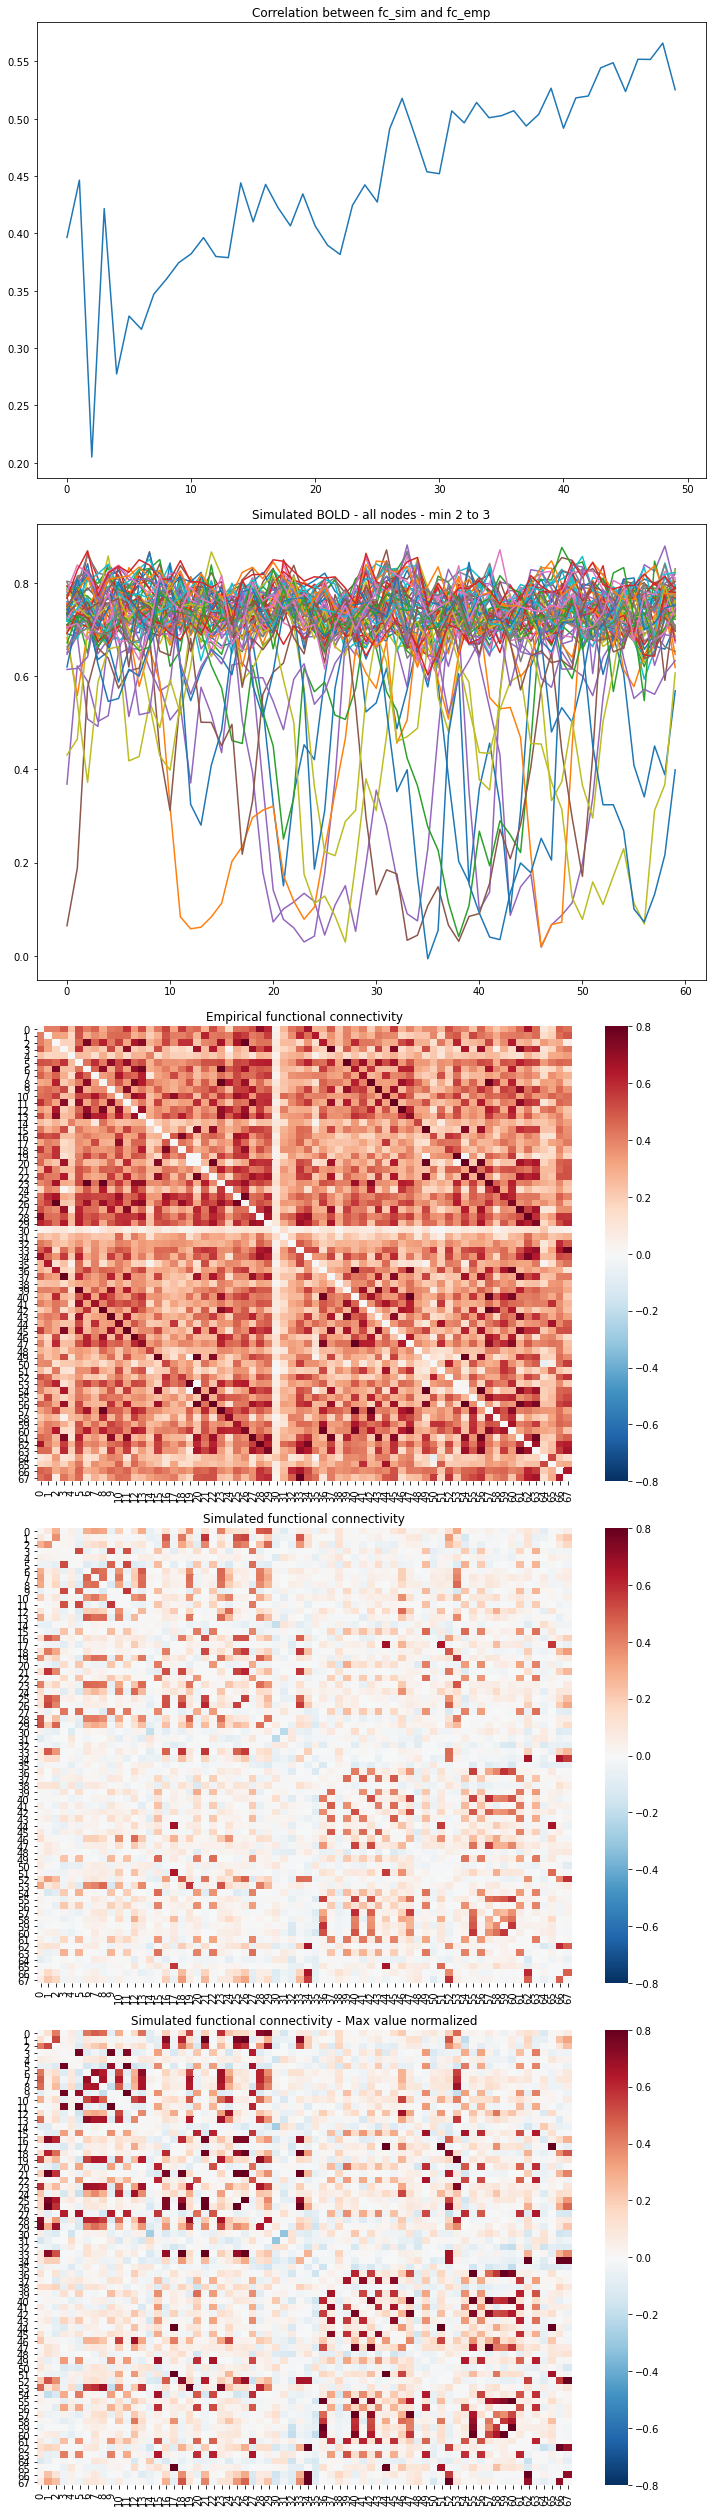

In [49]:
for i in range(3):
    trained_models[i+5] = visualize_sim_WWD(sub_id=i, step_size =0.02)